In [ ]:
# cv2 is the Python Version of OpenCV
import cv2
# matplotlib is used for displaying images
import matplotlib.pyplot as plt
%matplotlib inline
# numpy is used for matrix manipulations
import numpy as np
from google.colab.patches import cv2_imshow
import tensorflow as tf
import os
import io
import time
from PIL import Image

In [ ]:
#loading cnn trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/trained_model/trained.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#method to predict tumor for given input image
def img_pred(img5):
    opencvImage = cv2.cvtColor(np.array(img5), cv2.COLOR_RGB2BGR)
    # arr=opencvImage.copy()
    img = cv2.resize(img5,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]
    return p
    # if p==0:
    #     p='No Tumor'
    # elif p==1:
    #     p='The model predicts that there is Glioma tumor'
    # elif p==2:
    #     p='Meningioma Tumor'
    # else:
    #     p='Pituitary Tumor'

    # if p!=1:
    #     print(f'The Model predicts that it is a {p}')


In [ ]:
def preprocess(img):
  # OpenCV uses BGR while Matplotlib uses RGB format
  # Display the color image with matplotlib
  # print(uploader)
  global watersheding, thresholding
  # for name, file_info in uploader.value.items():
  #   img = Image.open(io.BytesIO(file_info['content']))
  orig_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    #arr=opencvImage.copy()
  plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

  gray_img = cv2.cvtColor( orig_img, cv2.COLOR_BGR2GRAY )
  print("grayscale")
  plt.imshow(gray_img,cmap='gray')
  plt.axis('off')
  plt.show()

  # To remove salt and pepper noise
  # Using 5*5 kernel
  median_filtered = cv2.medianBlur(gray_img, 5)
  print("salt and pepper noise cleared")
  plt.imshow(median_filtered ,cmap='gray')
  plt.axis('off')
  plt.show()

  #edge_detection
  # 3*3 Sobel Filters
  Gx= np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  #print("Gx \n", Gx)
  Gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
  #print("Gy \n", Gy)
  img_sobelx = cv2.Sobel(median_filtered,cv2.CV_8U,1,0,ksize=3)
  img_sobely = cv2.Sobel(median_filtered,cv2.CV_8U,0,1,ksize=3)
  #del f = Gx + Gy
  # Adding mask to the image
  img_sobel = img_sobelx + img_sobely+gray_img
  print("edge detection")
  plt.imshow(img_sobel,cmap='gray')
  plt.axis('off')
  plt.show()

  # Set threshold and maxValue
  threshold = 50
  maxValue = 255

  # Threshold the pixel values
  th, thresh = cv2.threshold(img_sobel, threshold, maxValue, cv2.THRESH_BINARY)
  # cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/Brain_tumor_detection_project/static/thresholding.jpg',thresh)
  print("threshold")
  plt.imshow(thresh,cmap='gray')
  plt.axis('off')
  plt.show()

  # To remove any small white noises in the image using morphological opening.
  kernel = np.ones((3,3),np.uint8)
  opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
  print("removing white noise")
  plt.imshow(opening,cmap='gray')
  plt.axis('off')
  plt.show()

  # Black region shows sure background area
  # Dilation increases object boundary to background.
  sure_bg = cv2.dilate(opening,kernel,iterations=3)
  print("dilation back")
  plt.imshow(sure_bg,cmap='gray')
  plt.axis('off')
  plt.show()

  #  White region shows sure foreground area
  dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
  ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
  print("dilation front")
  plt.imshow(sure_fg,cmap='gray')
  plt.axis('off')
  plt.show()

  # Identifying regions where we don't know whether foreground and background
  # Watershed algorithm
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg,sure_fg)
  print("dilation in between")
  plt.imshow(unknown,cmap='gray')
  plt.axis('off')
  plt.show()

  contours, hierarchy = cv2.findContours(sure_fg,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

  # Creating a numpy array for markers and converting the image to 32 bit using dtype paramter
  marker = np.zeros((gray_img.shape[0], gray_img.shape[1]),dtype = np.int32)

  marker = np.int32(sure_fg) + np.int32(sure_bg)

  # Marker Labelling
  for id in range(len(contours)):
      cv2.drawContours(marker,contours,id,id+2, -1)

  marker = marker + 1

  marker[unknown==255] = 0

  copy_img = orig_img.copy()

  water_img=cv2.watershed(copy_img, marker)
  print("watershed")
  # plt.savefig(water_img)
  imgplt = plt.imshow(marker)
  plt.colorbar()
  plt.show()

  #marked_image
  copy_img[marker==-1]=(0,0,255)
  cv2.imwrite('img.jpg',copy_img)
  print("marking the segmented ridges")
  plt.imshow(copy_img,cmap='gray')
  plt.axis('off')
  plt.show()

  # The basic purpose of the operation is to show only that part of the image having
  # more intensity which has the tumor that is the part of the image forming our desired extraction.
  kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(7,7))
  erosion = cv2.morphologyEx(median_filtered, cv2.MORPH_ERODE, kernel)
  print("intensify tumor")
  plt.imshow(erosion,cmap='gray')
  plt.axis('off')
  plt.show()
  # erosion=np.reshape(erosion, (1024, 720))
  # print(erosion)
  # return erosion
  #final output image after dilation
  # dilation = cv2.morphologyEx(erosion, cv2.MORPH_DILATE, kernel)
  # plt.imshow(dilation,cmap='gray')
  # plt.axis('off')
  # plt.show()

In [ ]:
#upload button to take input from local storage
import ipywidgets as widgets
from IPython.display import display,clear_output
uploader = widgets.FileUpload()
display(uploader)
button = widgets.Button(description='Predict')
display(button)
out = widgets.Output()
def on_button_clicked(_):
    #preprocess(uploader)
    with out:
        clear_output()
        preprocess(uploader)
        try:
            img_pred(uploader)
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
display(out)
#widgets.VBox([button,out])
#time.sleep(20)


FileUpload(value={}, description='Upload')

Button(description='Predict', style=ButtonStyle())

Output()

In [ ]:
!pip install flask-ngrok

In [ ]:
!pip install Flask-Uploads

  Created wheel for Flask-Uploads: filename=Flask_Uploads-0.2.1-py3-none-any.whl size=8069 sha256=e51eacf0ae8e617165b942876f0e1e2095e8c12a34685f344cf8bbbde9216e48
  Stored in directory: /root/.cache/pip/wheels/ac/f2/8a/652b34371f02b73cfd18126d14d1c6d31736e6a346c737962b
Successfully built Flask-Uploads


In [ ]:
!pip install werkzeug==0.16.0

     |████████████████████████████████| 327 kB 5.2 MB/s 
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 1.0.1
    Uninstalling Werkzeug-1.0.1:
      Successfully uninstalled Werkzeug-1.0.1


In [ ]:
!pip install Flask-Ext

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://d3bf102ef3f6.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [11/Aug/2021 07:19:55] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [11/Aug/2021 07:19:55] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [11/Aug/2021 07:20:00] "GET /about HTTP/1.1" 200 -
127.0.0.1 - - [11/Aug/2021 07:20:14] "GET /detect HTTP/1.1" 200 -


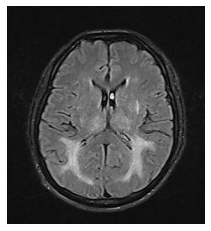

grayscale


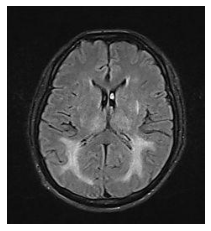

salt and pepper noise cleared


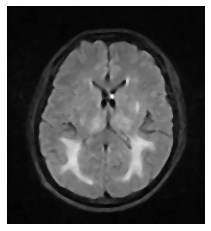

edge detection


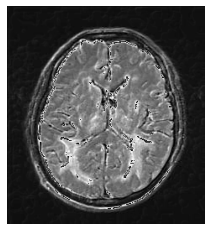

threshold


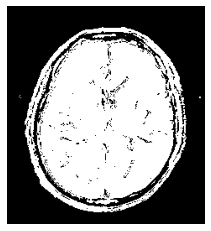

removing white noise


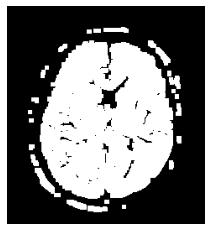

dilation back


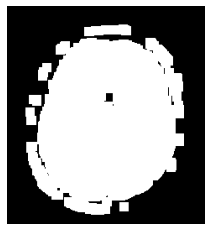

dilation front


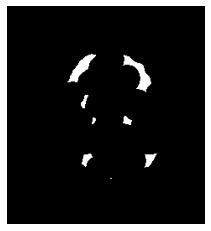

dilation in between


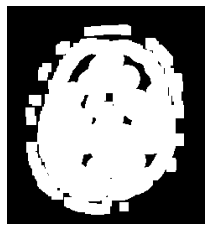

watershed


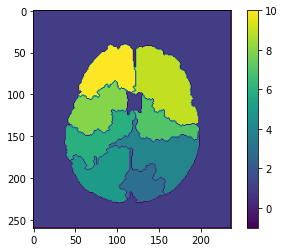

marking the segmented ridges


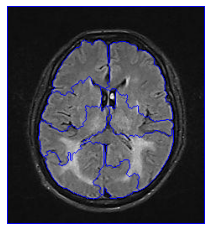

intensify tumor


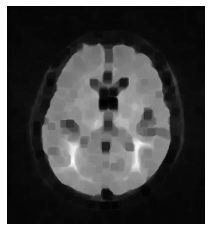

127.0.0.1 - - [11/Aug/2021 07:20:41] "POST /result HTTP/1.1" 200 -
127.0.0.1 - - [11/Aug/2021 07:20:50] "GET /static/css/bootstrap.min.css HTTP/1.1" 404 -


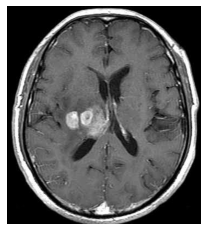

grayscale


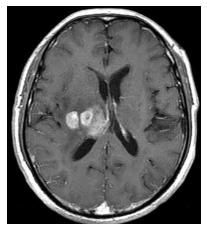

salt and pepper noise cleared


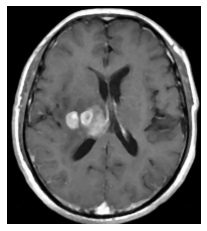

edge detection


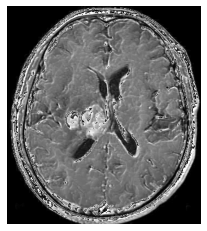

threshold


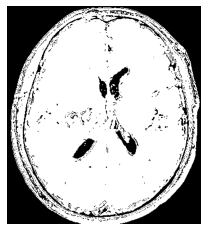

removing white noise


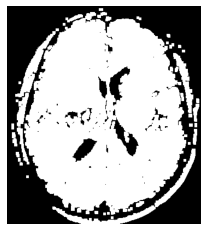

dilation back


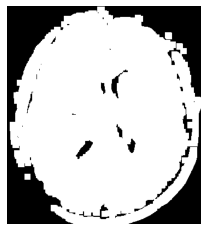

dilation front


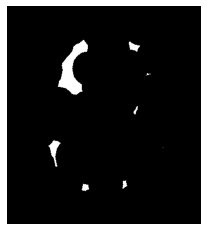

dilation in between


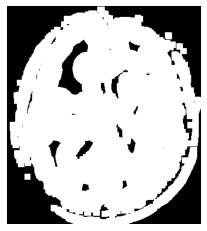

watershed


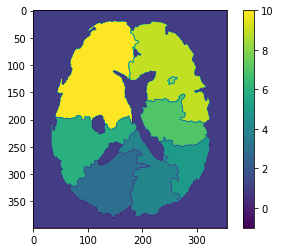

marking the segmented ridges


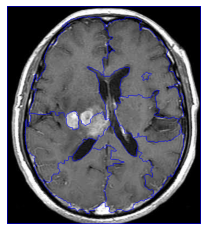

intensify tumor


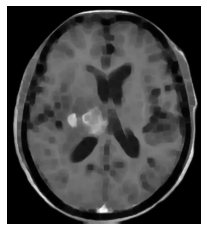

127.0.0.1 - - [11/Aug/2021 07:21:04] "POST /result HTTP/1.1" 200 -


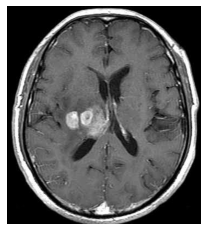

grayscale


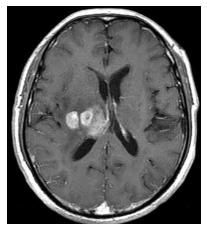

salt and pepper noise cleared


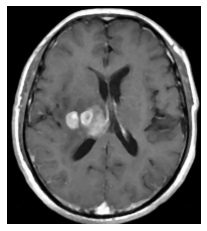

edge detection


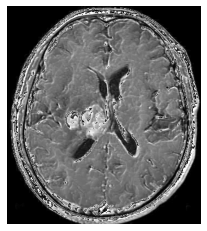

threshold


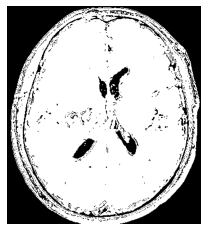

removing white noise


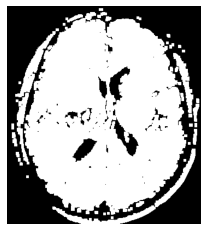

dilation back


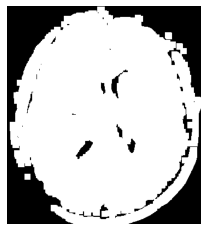

dilation front


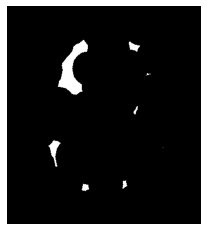

dilation in between


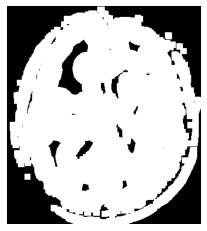

watershed


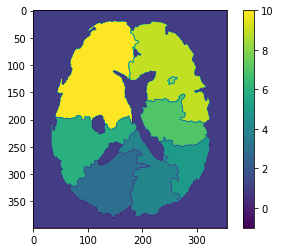

marking the segmented ridges


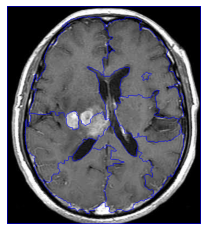

intensify tumor


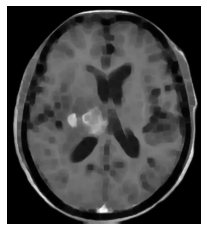

127.0.0.1 - - [11/Aug/2021 07:21:15] "POST /result HTTP/1.1" 200 -


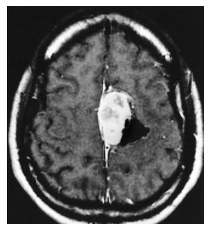

grayscale


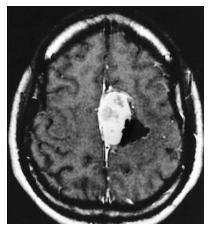

salt and pepper noise cleared


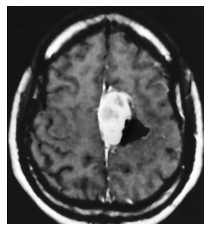

edge detection


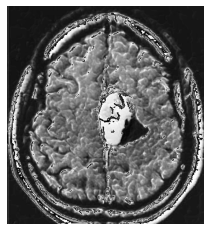

threshold


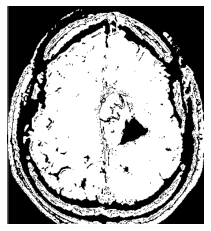

removing white noise


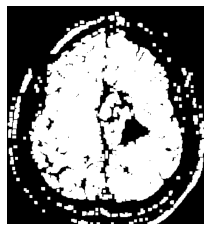

dilation back


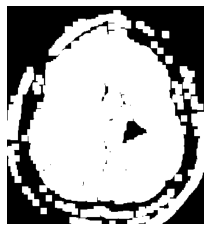

dilation front


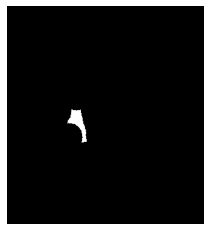

dilation in between


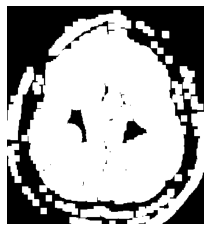

watershed


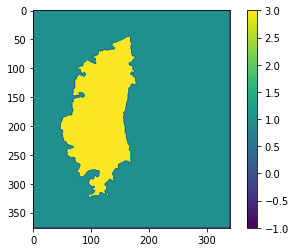

marking the segmented ridges


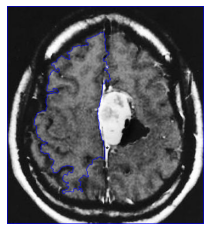

intensify tumor


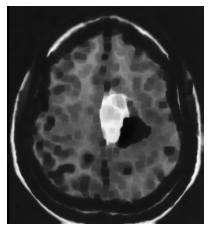

127.0.0.1 - - [11/Aug/2021 07:21:42] "POST /result HTTP/1.1" 200 -
127.0.0.1 - - [11/Aug/2021 07:21:51] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [11/Aug/2021 07:21:53] "GET /detect HTTP/1.1" 200 -
127.0.0.1 - - [11/Aug/2021 07:21:54] "GET /static/css/bootstrap.min.css HTTP/1.1" 404 -


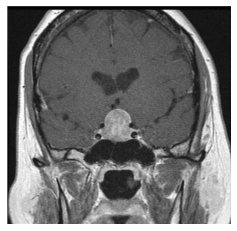

grayscale


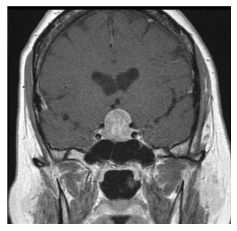

salt and pepper noise cleared


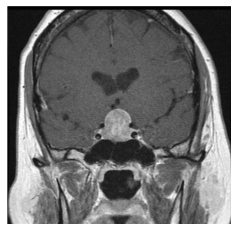

edge detection


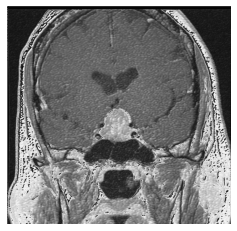

threshold


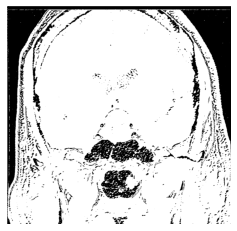

removing white noise


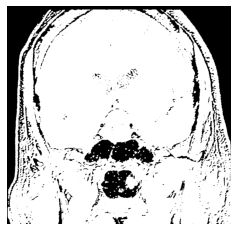

dilation back


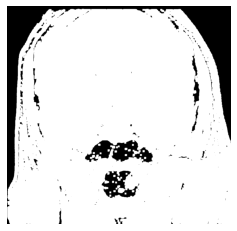

dilation front


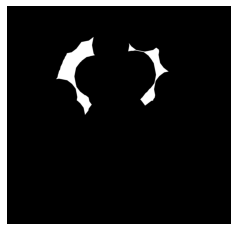

dilation in between


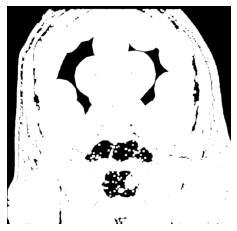

watershed


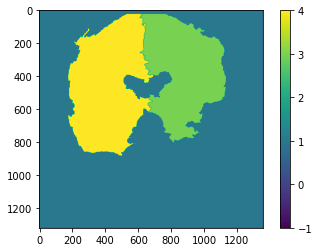

marking the segmented ridges


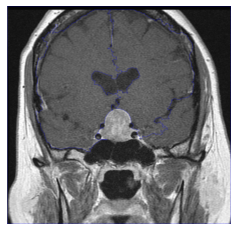

intensify tumor


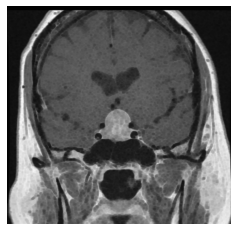

127.0.0.1 - - [11/Aug/2021 07:22:11] "POST /result HTTP/1.1" 200 -


In [ ]:
from flask_ngrok import run_with_ngrok
from werkzeug.utils import secure_filename
import numpy as np
from flask import Flask,render_template,request,jsonify
# import pickle
# from decimal import Decimal, ROUND_HALF_UP
# from keras import backend as K
from flask_uploads import UploadSet,configure_uploads
import os
import cv2

# global original
app = Flask(__name__, template_folder='/')
UPLOAD_FILE=os.path.join('/content/drive/MyDrive/Colab Notebooks/Brain_tumor_detection_project/static')
app.config['UPLOAD_FILE']=UPLOAD_FILE
# uploaded_img = UploadSet('image', extensions=('img'))
# configure_uploads(app, (uploaded_img,))
run_with_ngrok(app)
@app.route('/')
def home():
    return render_template('/content/drive/MyDrive/Colab Notebooks/Brain_tumor_detection_project/templates/index.html')

@app.route('/about')
def about():
    return render_template('/content/drive/MyDrive/Colab Notebooks/Brain_tumor_detection_project/templates/about .html')

@app.route('/detect')
def detect():
  return render_template('/content/drive/MyDrive/Colab Notebooks/Brain_tumor_detection_project/templates/detect.html')


@app.route('/result', methods = ['GET', 'POST'])
def result():
  if request.method == 'POST':
        f = request.files['file']
        f.save(os.path.join(app.config['UPLOAD_FILE'], secure_filename(f.filename)))
        img=os.path.join('/content/drive/MyDrive/Colab Notebooks/Brain_tumor_detection_project/static',f.filename)
        img1=cv2.imread(img)
        preprocess(img1)
        p=img_pred(img1)
  # return render_template('/content/drive/MyDrive/Colab Notebooks/Brain_tumor_detection_project/templates/result.html',name=res)

  if p==0:
    return render_template('/content/drive/MyDrive/Colab Notebooks/Brain_tumor_detection_project/templates/result.html', name='The model predicts there is NO TUMOR for this test case.', ty='' ,url1 =img)
  elif p==1:
    return render_template('/content/drive/MyDrive/Colab Notebooks/Brain_tumor_detection_project/templates/result.html',name='The model predicts the presence of TUMOR for this test case.', ty='The Tumor is classifed as MALIGNANT and the type being GLIOMA.', url1 =img)
  elif p==2:
    return render_template('/content/drive/MyDrive/Colab Notebooks/Brain_tumor_detection_project/templates/result.html',name='The model predicts the presence of TUMOR for this test case.', ty='The Tumor is classifed as BENIGN and the type being MENINGIOMA.', url1 =img)
  else:
    return render_template('/content/drive/MyDrive/Colab Notebooks/Brain_tumor_detection_project/templates/result.html',name='The model predicts the presence of TUMOR for this test case.', ty='The Tumor is classifed as BENIGN and the type being PITUITORY ADENOMAS.', url1 =img)
  # print("image saved")
  # return render_template("/content/drive/MyDrive/Colab Notebooks/Brain_tumor_detection_project/templates/detect.html")

app.run()

# New Section

In [ ]:
from flask_ngrok import run_with_ngrok
from werkzeug.utils import secure_filename
from flask import Flask,render_template,request,jsonify
from flask_uploads import UploadSet,configure_uploads
import os
import cv2

global original
app = Flask(__name__, template_folder='/')
UPLOAD_FILE=os.path.join('/content/drive/MyDrive/Colab Notebooks/Brain_tumor_detection_project/static')
app.config['UPLOAD_FILE']=UPLOAD_FILE
run_with_ngrok(app)
@app.route('/')
def home():
    return render_template('/content/drive/MyDrive/Colab Notebooks/Brain_tumor_detection_project/templates/file_upload.html')
